In [ ]:
! pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.0 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

#LSTM pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define a simple learning rate schedule
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler

#Read CSV File

In [ ]:
df = pd.read_csv('/content/cell.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466739 entries, 0 to 466738
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      0 non-null       float64
 1   Use CaseType (Input 1)          466739 non-null  object 
 2   LTE/5G UE Category (Input 2)    466739 non-null  object 
 3   Technology Supported (Input 3)  466739 non-null  object 
 4   Day (Input4)                    466739 non-null  object 
 5   Time (Input 5)                  466739 non-null  int64  
 6   QCI (Input 6)                   466739 non-null  int64  
 7   Packet Loss Rate (Reliability)  466739 non-null  float64
 8   Packet Delay Budget (Latency)   466739 non-null  object 
 9   Slice Type (Output)             466739 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 35.6+ MB


In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466739 entries, 0 to 466738
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Use CaseType (Input 1)          466739 non-null  object 
 1   LTE/5G UE Category (Input 2)    466739 non-null  object 
 2   Technology Supported (Input 3)  466739 non-null  object 
 3   Day (Input4)                    466739 non-null  object 
 4   Time (Input 5)                  466739 non-null  int64  
 5   QCI (Input 6)                   466739 non-null  int64  
 6   Packet Loss Rate (Reliability)  466739 non-null  float64
 7   Packet Delay Budget (Latency)   466739 non-null  object 
 8   Slice Type (Output)             466739 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 32.0+ MB


#Data Augmentaion

In [ ]:
# Adding random missing values (Data Augmentation)
missing_percentage = 0.07
mask = np.random.rand(*df.shape) < missing_percentage
df[mask] = np.nan

#Pre-processing

In [ ]:
df = df.rename(columns={'Use CaseType (Input 1)': 'Casetype'})
df = df.rename(columns={'LTE/5G UE Category (Input 2)': 'UE_category'})
df = df.rename(columns={'Technology Supported (Input 3)': 'Technology'})
df = df.rename(columns={'Day (Input4)': 'Day'})
df = df.rename(columns={'Time (Input 5)': 'Time'})
df = df.rename(columns={'QCI (Input 6)': 'QCI'})
df = df.rename(columns={'Packet Loss Rate (Reliability)': 'Reliability'})
df = df.rename(columns={'Packet Delay Budget (Latency)': 'Latency'})
df = df.rename(columns={'Slice Type (Output)': 'Slice'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466739 entries, 0 to 466738
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Casetype     434031 non-null  object 
 1   UE_category  433968 non-null  object 
 2   Technology   433842 non-null  object 
 3   Day          434114 non-null  object 
 4   Time         434200 non-null  float64
 5   QCI          433861 non-null  float64
 6   Reliability  433945 non-null  float64
 7   Latency      433966 non-null  object 
 8   Slice        433993 non-null  object 
dtypes: float64(3), object(6)
memory usage: 32.0+ MB


In [ ]:
df['Casetype'].unique()

array(['Smartphone', nan, 'IoT Devices', 'Smart Transportation',
       'Industry 4.0', 'AR/VR/Gaming', 'Healthcare', 'Public Safety/E911',
       'Smart City & Home'], dtype=object)

#Encoding

In [ ]:
features_to_encode = ['Day','Time']
label_encoders = {}
for feature in features_to_encode:
    label_encoder = LabelEncoder()
    df[feature] = label_encoder.fit_transform(df[feature])
    label_encoders[feature] = label_encoder

In [ ]:
df_encoded = pd.get_dummies(df, columns=['Casetype','UE_category','Technology','Reliability','Latency','Slice'])
df_encoded

,Day,Time,QCI,Casetype_AR/VR/Gaming,Casetype_Healthcare,Casetype_Industry 4.0,Casetype_IoT Devices,Casetype_Public Safety/E911,Casetype_Smart City & Home,Casetype_Smart Transportation,...,Technology_LTE/5G,Reliability_1e-06,Reliability_0.001,Reliability_0.01,Latency_<10ms,Latency_<300ms,Latency_<50ms,Slice_URLLC,Slice_eMBB,Slice_mMTC
0,1,0,1.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,True,False
1,1,23,NaN,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False
2,1,0,3.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False
3,1,0,4.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False
4,1,0,65.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466734,3,22,7.0,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
466735,3,22,8.0,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
466736,3,22,9.0,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
466737,3,22,69.0,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False


In [ ]:
df_encoded.set_index(['Day', 'Time'], inplace=True)
print(df)

            Casetype UE_category           Technology  Day  Time   QCI  \
0         Smartphone           1               LTE/5G    1     0   1.0   
1         Smartphone           1               LTE/5G    1    23   NaN   
2         Smartphone           1               LTE/5G    1     0   3.0   
3         Smartphone           1               LTE/5G    1     0   4.0   
4         Smartphone           1               LTE/5G    1     0  65.0   
...              ...         ...                  ...  ...   ...   ...   
466734  Industry 4.0          20                  NaN    3    22   7.0   
466735  Industry 4.0          20  IoT (LTE-M, NB-IoT)    3    22   8.0   
466736  Industry 4.0          20  IoT (LTE-M, NB-IoT)    3    22   9.0   
466737  Industry 4.0          20  IoT (LTE-M, NB-IoT)    3    22  69.0   
466738  Industry 4.0          20  IoT (LTE-M, NB-IoT)    3    22  70.0   

        Reliability Latency  Slice  
0               NaN   <50ms   eMBB  
1          0.010000   <50ms   eMBB  


#Time series forecasting for URLLC Slice


Epoch 1/200
598/598 [==============================] - 21s 26ms/step - loss: 0.0333 - mse: 0.0333 - accuracy: 0.9618 - val_loss: 5.1852e-06 - val_mse: 5.1852e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0273 - mse: 0.0273 - accuracy: 0.9708 - val_loss: 3.2608e-06 - val_mse: 3.2608e-06 - val_accuracy: 1.0000 - lr: 9.0000e-04
Epoch 3/200
598/598 [==============================] - 9s 16ms/step - loss: 0.0273 - mse: 0.0273 - accuracy: 0.9708 - val_loss: 4.8413e-05 - val_mse: 4.8413e-05 - val_accuracy: 1.0000 - lr: 8.1000e-04
Epoch 4/200
598/598 [==============================] - 8s 14ms/step - loss: 0.0273 - mse: 0.0273 - accuracy: 0.9708 - val_loss: 4.8449e-05 - val_mse: 4.8449e-05 - val_accuracy: 1.0000 - lr: 7.2900e-04
Epoch 5/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0273 - mse: 0.0273 - accuracy: 0.9708 - val_loss: 3.8318e-06 - val_mse: 3.8318e-06 - val_accuracy: 1.0000 - lr: 6.5610e

<Axes: title={'center': 'Accuracy'}>

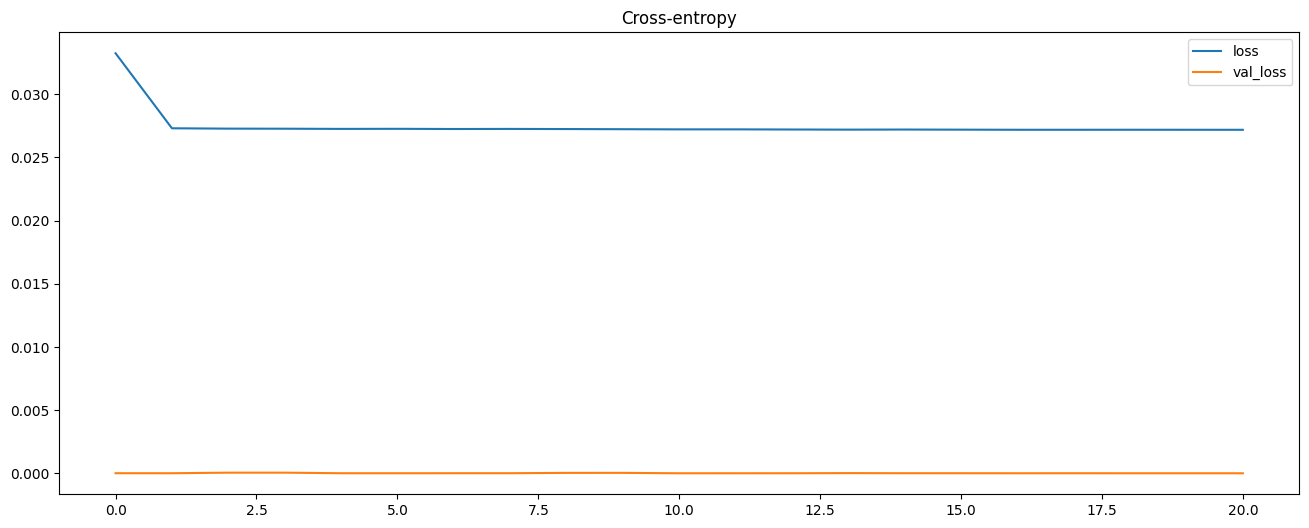

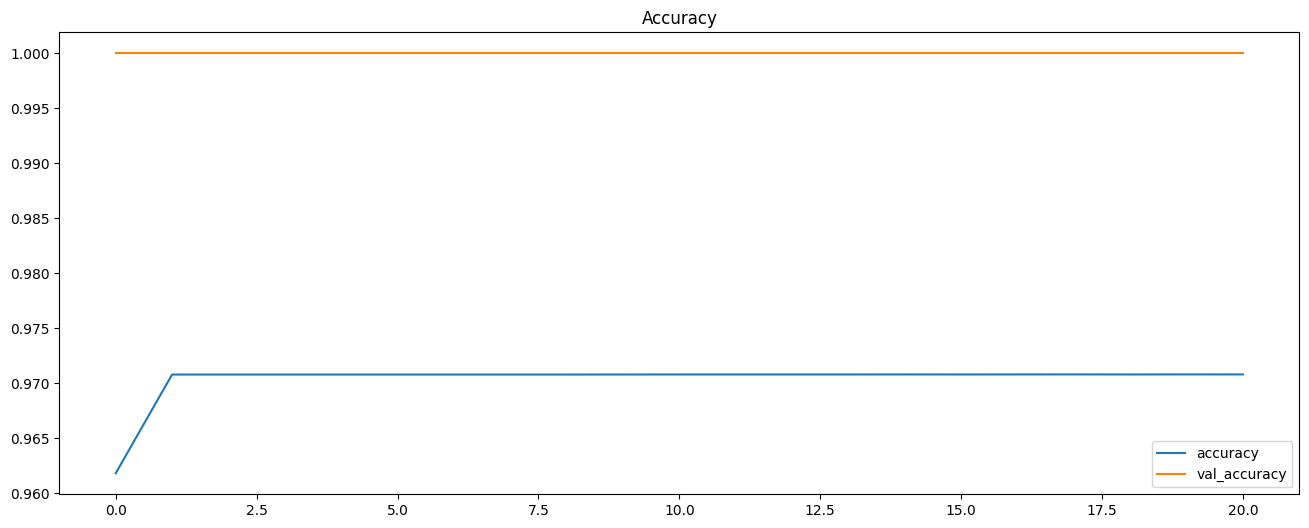

In [ ]:
# Reset the index if needed
df_reset = df_encoded.reset_index()

# Assume 'Slice_URLLC' is the target variable
target_variable = 'Slice_URLLC'

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_reset[[target_variable]])

# Convert the data to a time series sequence
sequence_length = 10  # Adjust as needed
X, y = [], []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i : i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#LSTM pipeline
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

# Define a simple learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    decay = 0.9  # Learning rate decay factor
    lr = initial_lr * decay**epoch
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history=model.fit(X_train, y_train,
          epochs=200,
          batch_size=500,
          validation_split=0.2,
          callbacks=[early_stopping, lr_scheduler],
          )
#Model Evaluation
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy", figsize=(16, 6))
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy", figsize=(16, 6))

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform the normalized values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

2918/2918 [==============================] - 10s 3ms/step
Mean Squared Error: 0.05910903831417219


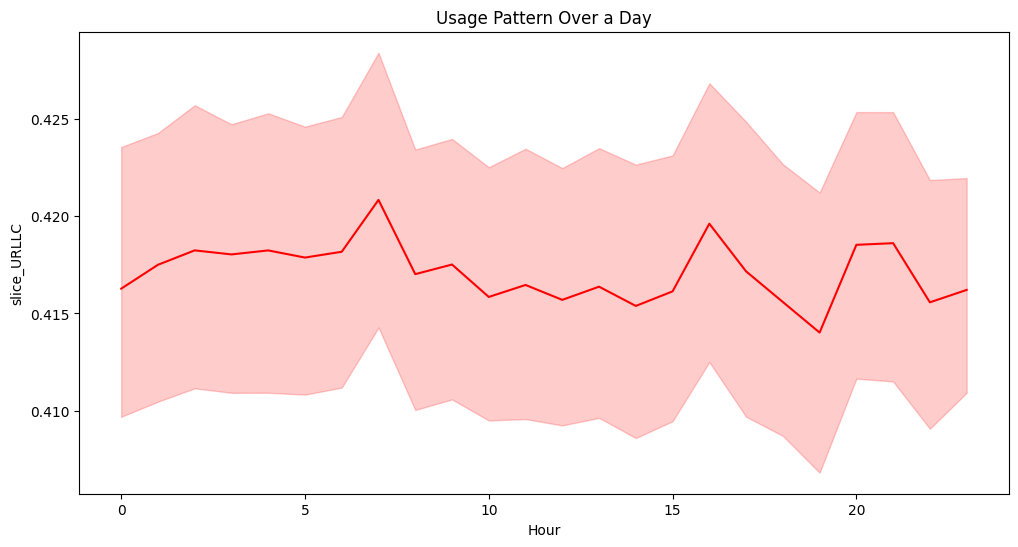

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Time', y='Slice_URLLC', data=df_encoded, color='red')

plt.title('Usage Pattern Over a Day')
plt.xlabel('Hour')
plt.ylabel('slice_URLLC')
plt.show()

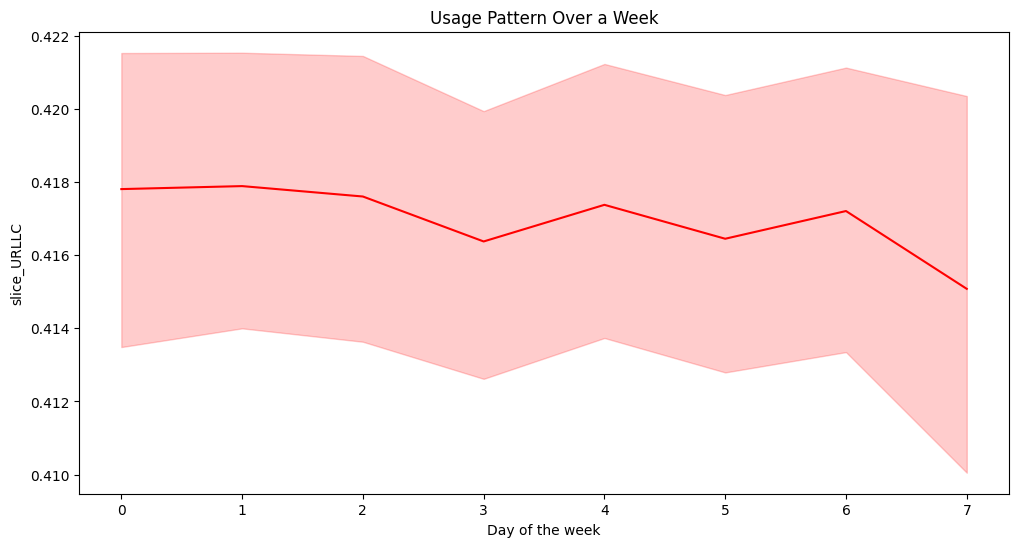

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Day', y='Slice_URLLC', data=df_encoded, color='red')

plt.title('Usage Pattern Over a Week')
plt.xlabel('Day of the week')
plt.ylabel('slice_URLLC')
plt.show()

#Time series forecasting for eMBB Slice

Epoch 1/200
598/598 [==============================] - 11s 14ms/step - loss: 0.0219 - mse: 0.0219 - accuracy: 0.9751 - val_loss: 0.0288 - val_mse: 0.0288 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 2/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0185 - mse: 0.0185 - accuracy: 0.9803 - val_loss: 0.0284 - val_mse: 0.0284 - val_accuracy: 0.9696 - lr: 9.0000e-04
Epoch 3/200
598/598 [==============================] - 9s 16ms/step - loss: 0.0184 - mse: 0.0184 - accuracy: 0.9803 - val_loss: 0.0288 - val_mse: 0.0288 - val_accuracy: 0.9696 - lr: 8.1000e-04
Epoch 4/200
598/598 [==============================] - 8s 13ms/step - loss: 0.0184 - mse: 0.0184 - accuracy: 0.9803 - val_loss: 0.0284 - val_mse: 0.0284 - val_accuracy: 0.9696 - lr: 7.2900e-04
Epoch 5/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0184 - mse: 0.0184 - accuracy: 0.9803 - val_loss: 0.0283 - val_mse: 0.0283 - val_accuracy: 0.9696 - lr: 6.5610e-04
Epoch 6/200
598/598 [===============

<Axes: title={'center': 'Accuracy'}>

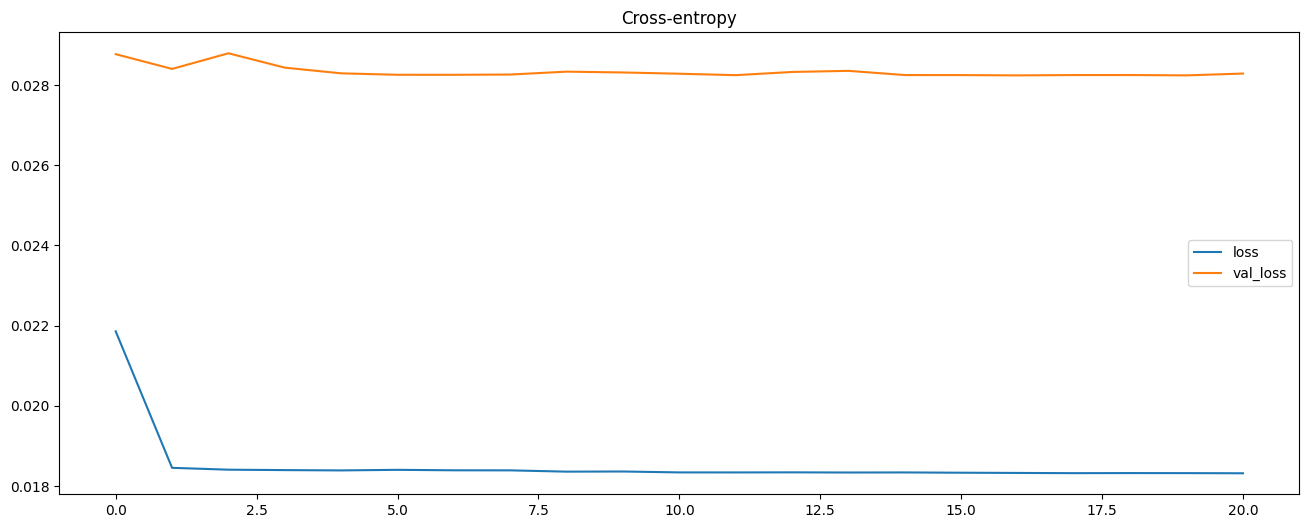

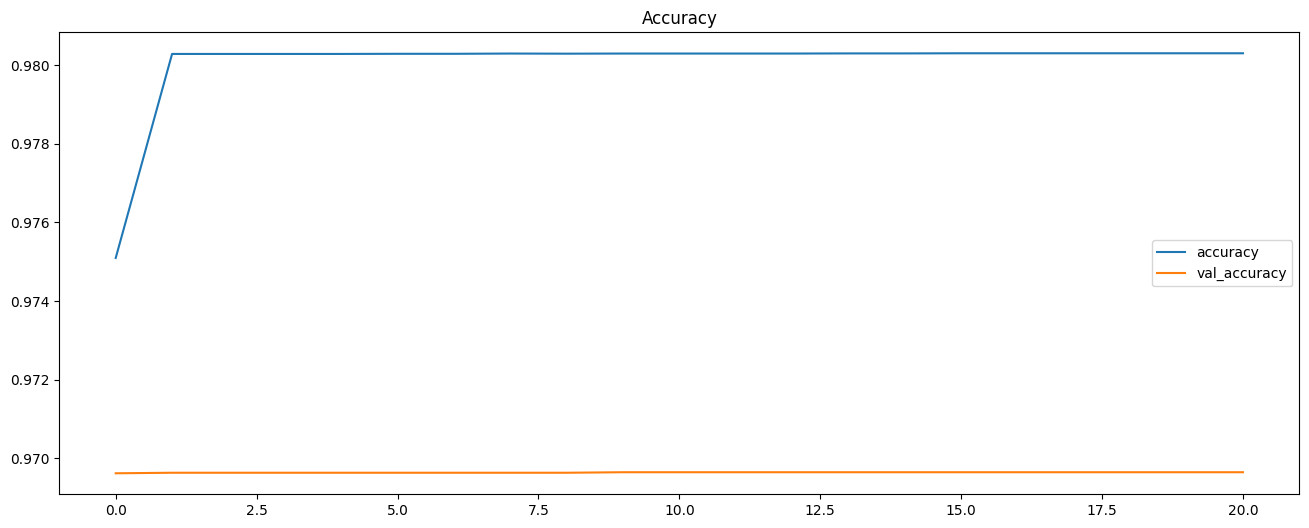

In [ ]:
# Reset the index if needed
df_reset = df_encoded.reset_index()

# Assume 'Slice_URLLC' is the target variable
target_variable = 'Slice_eMBB'

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_reset[[target_variable]])

# Convert the data to a time series sequence
sequence_length = 10  # Adjust as needed
X, y = [], []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i : i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#LSTM pipeline
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    decay = 0.9  # Learning rate decay factor
    lr = initial_lr * decay**epoch
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history=model.fit(X_train, y_train,
          epochs=200,
          batch_size=500,
          validation_split=0.2,
          callbacks=[early_stopping, lr_scheduler],
          )
#Model Evaluation
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy", figsize=(16, 6))
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy", figsize=(16, 6))

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform the normalized values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

2918/2918 [==============================] - 10s 3ms/step
Mean Squared Error: 0.007214892689472292


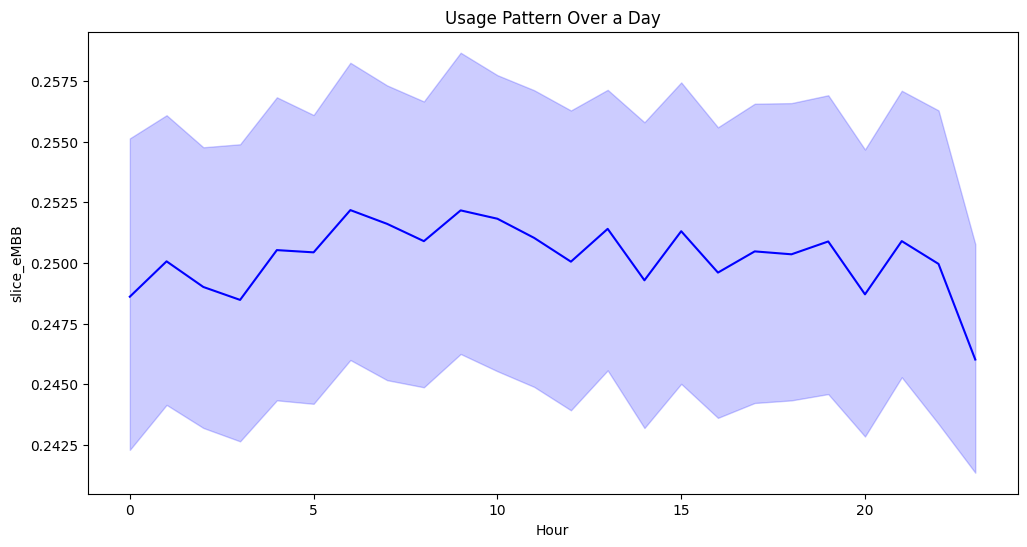

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Time', y='Slice_eMBB',  data=df_encoded, color='blue')

plt.title('Usage Pattern Over a Day')
plt.xlabel('Hour')
plt.ylabel('slice_eMBB')
plt.show()

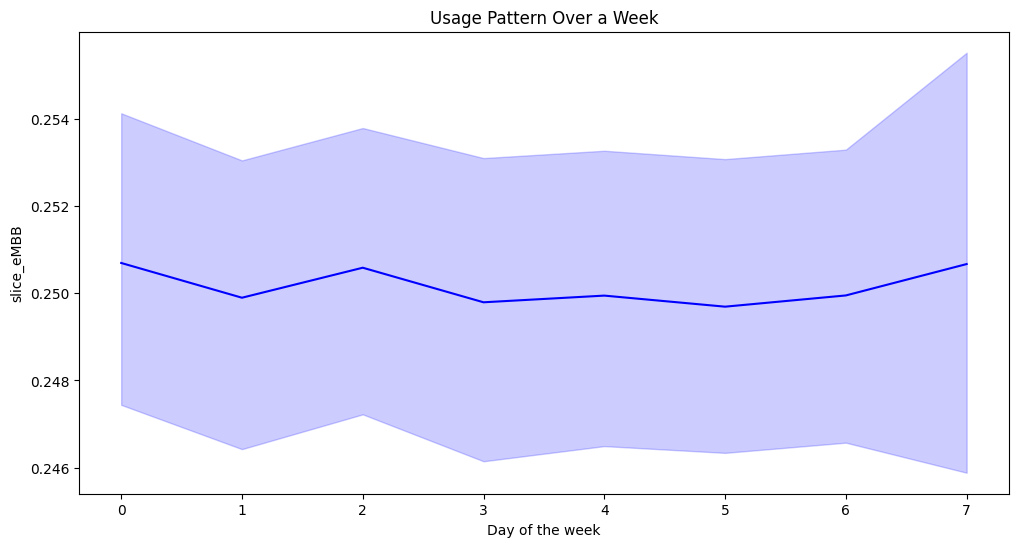

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Day', y='Slice_eMBB',  data=df_encoded, color='blue')

plt.title('Usage Pattern Over a Week')
plt.xlabel('Day of the week')
plt.ylabel('slice_eMBB')
plt.show()

#Time series forecasting for mMTC Slice

Epoch 1/200
598/598 [==============================] - 11s 17ms/step - loss: 0.0275 - mse: 0.0275 - accuracy: 0.9691 - val_loss: 0.0362 - val_mse: 0.0362 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 2/200
598/598 [==============================] - 9s 16ms/step - loss: 0.0201 - mse: 0.0201 - accuracy: 0.9785 - val_loss: 0.0362 - val_mse: 0.0362 - val_accuracy: 0.9612 - lr: 9.0000e-04
Epoch 3/200
598/598 [==============================] - 8s 13ms/step - loss: 0.0200 - mse: 0.0200 - accuracy: 0.9785 - val_loss: 0.0365 - val_mse: 0.0365 - val_accuracy: 0.9612 - lr: 8.1000e-04
Epoch 4/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0200 - mse: 0.0200 - accuracy: 0.9785 - val_loss: 0.0362 - val_mse: 0.0362 - val_accuracy: 0.9612 - lr: 7.2900e-04
Epoch 5/200
598/598 [==============================] - 10s 16ms/step - loss: 0.0200 - mse: 0.0200 - accuracy: 0.9785 - val_loss: 0.0361 - val_mse: 0.0361 - val_accuracy: 0.9612 - lr: 6.5610e-04
Epoch 6/200
598/598 [===============

<Axes: title={'center': 'Accuracy'}>

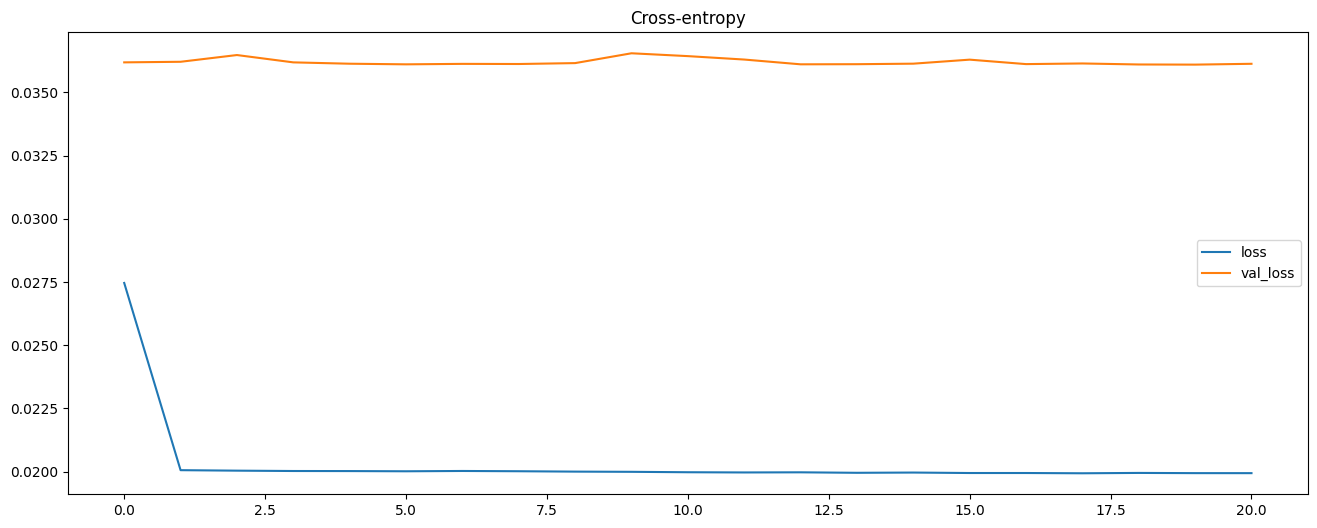

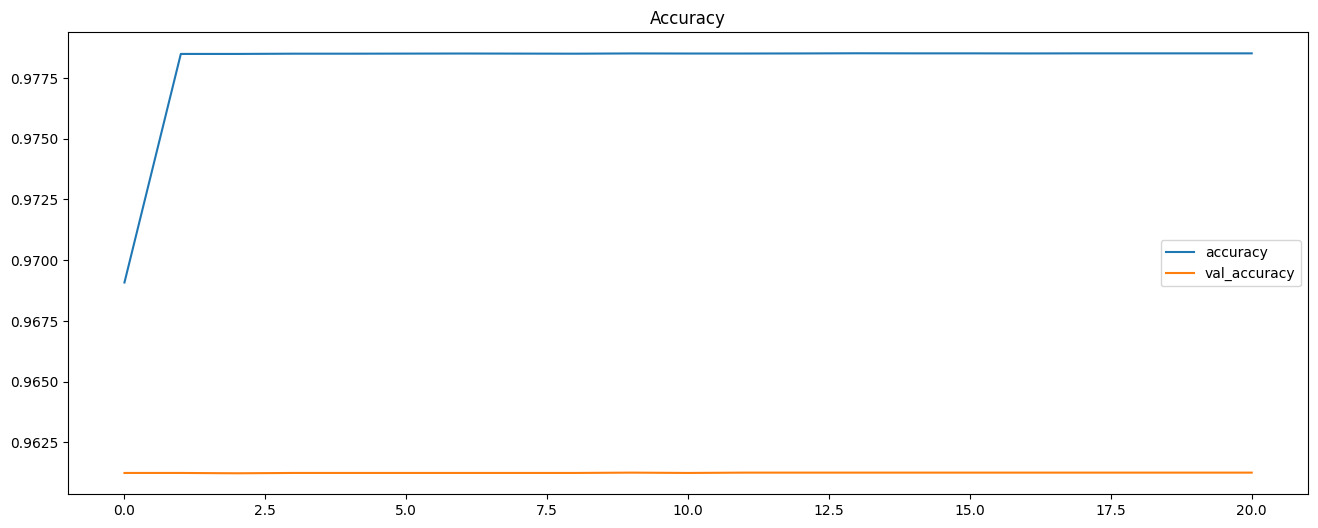

In [ ]:
# Reset the index if needed
df_reset = df_encoded.reset_index()

# Assume 'Slice_URLLC' is the target variable
target_variable = 'Slice_mMTC'

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df_reset[[target_variable]])

# Convert the data to a time series sequence
sequence_length = 10  # Adjust as needed
X, y = [], []
for i in range(len(df_normalized) - sequence_length):
    X.append(df_normalized[i : i + sequence_length])
    y.append(df_normalized[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#LSTM pipeline
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    decay = 0.9  # Learning rate decay factor
    lr = initial_lr * decay**epoch
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history=model.fit(X_train, y_train,
          epochs=200,
          batch_size=500,
          validation_split=0.2,
          callbacks=[early_stopping, lr_scheduler],
          )

#Model Evaluation
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy", figsize=(16, 6))
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy", figsize=(16, 6))

In [ ]:
y_pred = model.predict(X_test)

# Inverse transform the normalized values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

2918/2918 [==============================] - 10s 3ms/step
Mean Squared Error: 4.7665486922278096e-06


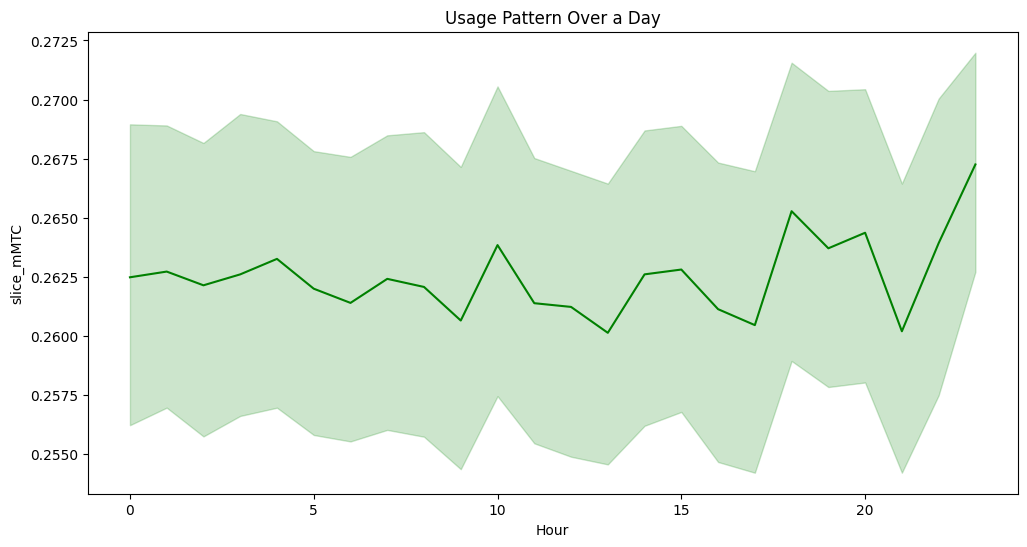

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Time', y='Slice_mMTC',  data=df_encoded, color='green')

plt.title('Usage Pattern Over a Day')
plt.xlabel('Hour')
plt.ylabel('slice_mMTC')
plt.show()

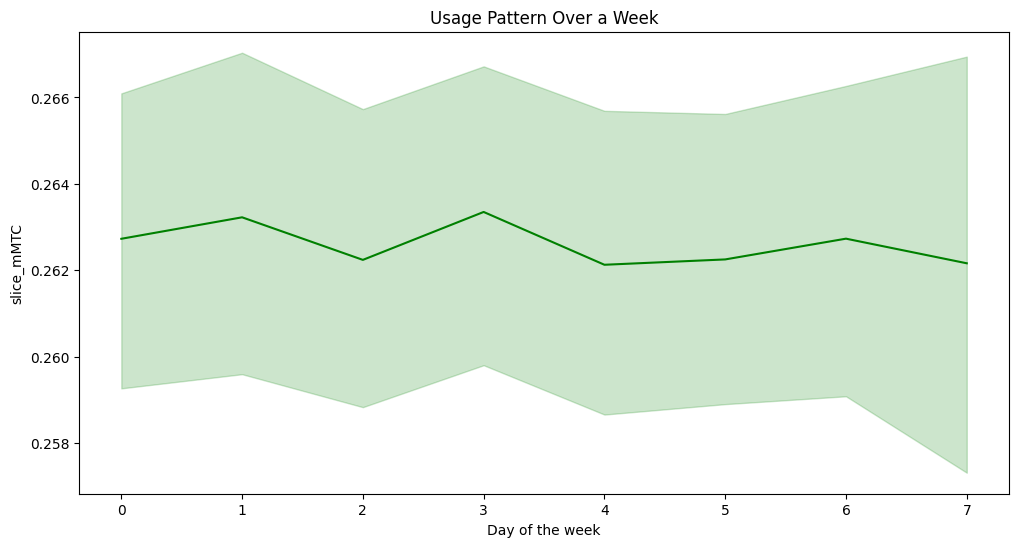

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 6))

# Plot the line
sns.lineplot(x='Day', y='Slice_mMTC',  data=df_encoded, color='green')

plt.title('Usage Pattern Over a Week')
plt.xlabel('Day of the week')
plt.ylabel('slice_mMTC')
plt.show()

#Comparison of load forecasting among eMBB, mMTC, URLLC user

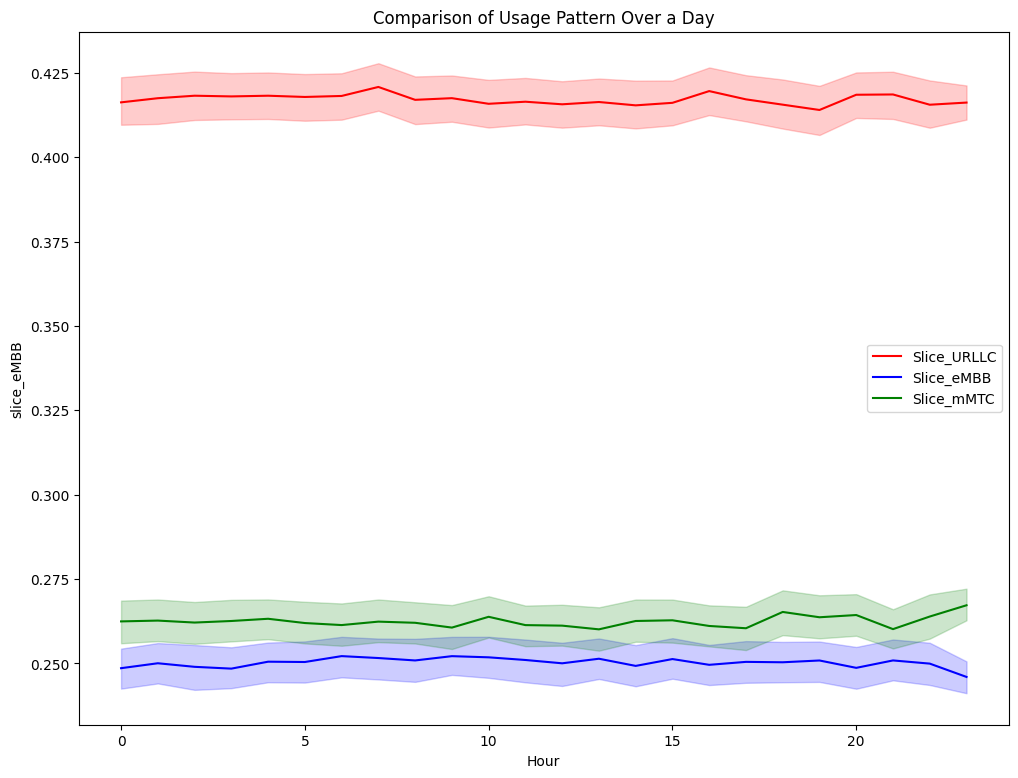

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 9))

# Plot the line
sns.lineplot(x='Time', y='Slice_URLLC',  data=df_encoded, color='red', label='Slice_URLLC')
sns.lineplot(x='Time', y='Slice_eMBB',  data=df_encoded, color='blue', label='Slice_eMBB')
sns.lineplot(x='Time', y='Slice_mMTC',  data=df_encoded, color='green', label='Slice_mMTC')

plt.title('Comparison of Usage Pattern Over a Day')
plt.xlabel('Hour')
plt.ylabel('slice_eMBB')
plt.show()

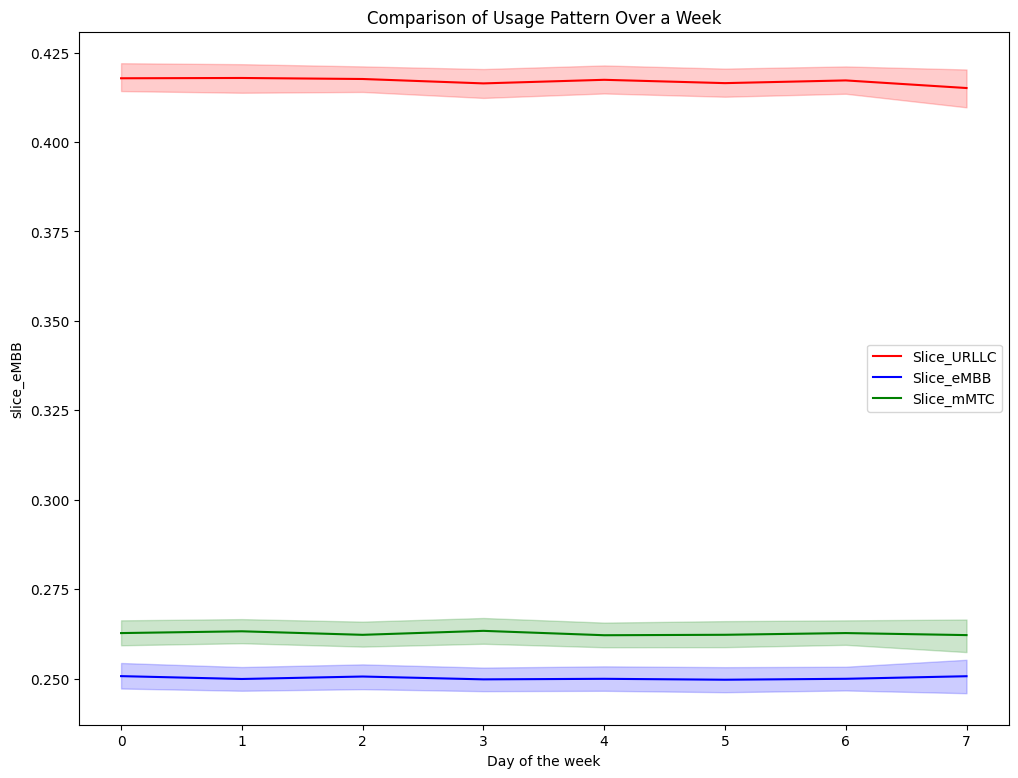

In [ ]:
# Plot the line plot
plt.figure(figsize=(12, 9))

# Plot the line
sns.lineplot(x='Day', y='Slice_URLLC',  data=df_encoded, color='red', label='Slice_URLLC')
sns.lineplot(x='Day', y='Slice_eMBB',  data=df_encoded, color='blue', label='Slice_eMBB')
sns.lineplot(x='Day', y='Slice_mMTC',  data=df_encoded, color='green', label='Slice_mMTC')

plt.title('Comparison of Usage Pattern Over a Week')
plt.xlabel('Day of the week')
plt.ylabel('slice_eMBB')
plt.show()